#ModelV7 |GPT Assisted

##Parameters

In [97]:
n_steps=60
patience=40
epoch=100
sizetest=0.2
sizetrain=0.8
sizebatch=2
dropout=0.3
learnrate=0.00001

#keep training at 80 20, 

##Imports

In [98]:
#OUR NEW MODEL TO TRAIN

#get the data
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib 
import  matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

snp = pd.read_csv(r'C:\Users\kalee\Downloads\Vix files\S&P 500 1ynow.csv')
snp['Price'] = snp['Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp['Open'] = snp['Open'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp['High'] = snp['High'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp['Low'] = snp['Low'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp['Price'] = snp['Price'].astype(float)
snp['Open'] = snp['Open'].astype(float)
snp['High'] = snp['High'].astype(float)
snp['Low'] = snp['Low'].astype(float)

snp.reset_index()
snp=snp[['Open','High','Low','Price']]

snp5 = pd.read_csv(r'C:\Users\kalee\Downloads\Vix files\S&P 500 10y.csv')
snp5['Price'] = snp5['Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp5['Open'] = snp5['Open'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp5['High'] = snp5['High'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp5['Low'] = snp5['Low'].apply(lambda x: float(x.split()[0].replace(',', '')))
snp5['Price'] = snp5['Price'].astype(float)
snp5['Open'] = snp5['Open'].astype(float)
snp5['High'] = snp5['High'].astype(float)
snp5['Low'] = snp5['Low'].astype(float)

snp5.reset_index()
snp5=snp5[['Open','High','Low','Price']]

vix5 = pd.read_csv(r'C:\Users\kalee\Downloads\Vix files\^Vix10y.csv')
vixarray5=vix5
vixarray5=vixarray5[['Open','High','Low']]
vixarray5.reset_index()
vixarray5=pd.concat([vixarray5,snp5], axis=1)
#vixarray5=np.array(vixarray5)

vix = pd.read_csv(r'C:\Users\kalee\Downloads\Vix files\^Vix1ynow.csv')
vixarray=vix
vixarray=vixarray[['Open','High','Low']]
vixarray.reset_index()
vixarray=pd.concat([vixarray,snp], axis=1)
#vixarray=np.array(vixarray)

In [99]:
sc=MinMaxScaler(feature_range=(-1,1))
vixarray=sc.fit_transform(vixarray)
vixarray5=sc.fit_transform(vixarray5)
#snparray=sc.fit_transform(snparray)
#snparray5=sc.fit_transform(snparray5)
vixsc=sc.fit_transform(vix[['Open','High','Low']])
vixsc5=sc.fit_transform(vix5[['Open','High','Low']])

##Data Preperation

In [100]:
#split into training x,y and testing x,y
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
train, test = train_test_split(vixarray5, test_size=sizetest, train_size=sizetrain, shuffle=False)


# convert into input/output
Xtrain, ytrain = split_sequences(train, n_steps)
Xtest, ytest = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = Xtrain.shape[2]
#now we should have training and test data ready to use in model


In [101]:
Xtest.shape[2]

7

##Create Model

In [102]:
#MODEL VERSIONS
#steps 60 dropout 0.2 patience 50 epochs 800 result pretty good
#steps 60 dropout 0.5 patience 50 epochs 800  loss: 0.0015 val_loss: 6.6952e-04 similar to previous
#steps 45 dropout 0.5 patience 50 epochs 800  loss: 0.0016 val_loss: 5.6478e-04 similar to previous
#steps 45 dropout 0.7 patience 30 epochs 800  loss: 0.0028 val_loss: 6.5146e-04 not as good
#steps 60 dropout 0.6 patience 30 epochs 800  loss: 0.0019 val_loss: 7.3998e-04 pretty good
#steps 60 minmax -1,1 dropout 0.6 patience 30 epochs 800 loss: 0.0019 val_loss: 7.3998e-04 pretty good
#steps 60 minmax -1,1 normalization layer dropout 0.6 patience 30 epochs 800 loss: 0.0119 val_loss: 0.0025 pretty good
#steps 80 minmax -1,1 normalization layer second last dropout 0.6 patience 30 epochs 800 loss: 0.0161 val_loss: 0.0020 pretty good
#steps 80 minmax -1,1 normalization layer second dropout 0.6 patience 30 epochs 800 everything got super smoothed out
#steps 60 minmax -1,1 patience 10 epochs 200 batch size 32 loss: 0.0029 - val_loss: 0.0012 possibly the best
#steps 60 minmax -1,1 patience 15 epochs 200 batch size 16 loss: 0.0027 - val_loss: 0.0013 similar
#steps 60 minmax -1,1 patience 15 epochs 200 batch size 64 loss: 0.0027 - val_loss: 0.0024 similar may identify better
#steps 60 minmax -1,1 dropout 0.6 patience 20 epochs 200 batch size 64
#steps 60 minmax -1,1 dropout 0 patience 30 epochs 200 batch size 8 loss: 0.0027 - val_loss: 0.0014
#steps 60 minmax -1,1 dropout 0 patience 30 epochs 200 batch size 8 loss: 0.0021 - val_loss: 0.0011 may be the best
#steps 30 minmax -1,1 dropout 0 patience 30 epochs 200 batch size 4 loss: 0.0021 - val_loss: 0.0014 probably the best
#steps 30 minmax -1,1 dropout 0 patience 30 epochs 200 batch size 2 loss: 0.0021 - val_loss: 0.0014 probably the best

In [103]:
#CHATGPT model
model = Sequential([
    LSTM(units=128, input_shape=(n_steps, 7), return_sequences=True),
    Dropout(dropout),
    #LSTM(units=64, return_sequences=True),
    #Dropout(dropout),
    LSTM(units=64),
    Dropout(dropout),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=n_features)
])

# Compile the model
#.01
optimizer = keras.optimizers.Adam(learning_rate=learnrate)
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=patience)

# Fit the model
history=model.fit(x=Xtrain, y=ytrain, validation_data=(Xtest,ytest), epochs=epoch, batch_size=sizebatch, callbacks=[early_stop])

Epoch 1/100
1178/1178 [==============================] - 38s 30ms/step - loss: 0.2135 - val_loss: 0.2298
Epoch 2/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0754 - val_loss: 0.2230
Epoch 3/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0559 - val_loss: 0.1918
Epoch 4/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0458 - val_loss: 0.1588
Epoch 5/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0379 - val_loss: 0.1349
Epoch 6/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0334 - val_loss: 0.1186
Epoch 7/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0297 - val_loss: 0.1078
Epoch 8/100
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0260 - val_loss: 0.0989
Epoch 9/100
1178/1178 [==============================] - 35s 29ms/step - loss: 0.0235 - val_loss: 0.0946
Epoch 10/100
1178/1178 [==============================]

In [104]:
#Now we have to define our model and train it
# define model
#model = Sequential()
#model.add(BatchNormalization())
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(LSTM(100, activation='relu'))
#model.add(Dropout(0.6))
#model.add(Dense(25))

#model.add(Dense(n_features))

#model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
#early_stop = EarlyStopping(monitor='val_loss', patience=30)
#history = model.fit(x=Xtrain,y=ytrain,validation_data=(Xtest,ytest), epochs=800, callbacks=[early_stop])


Text(0, 0.5, "Loss-'MSE'")

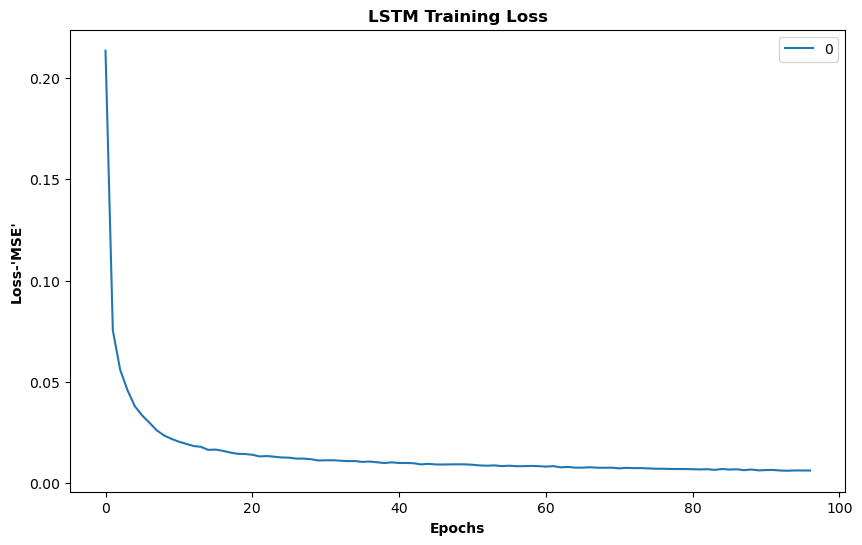

In [105]:
loss = pd.DataFrame(model.history.history['loss'])
loss.plot(figsize=(10,6))
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold')

Text(0, 0.5, "Loss-'MSE'")

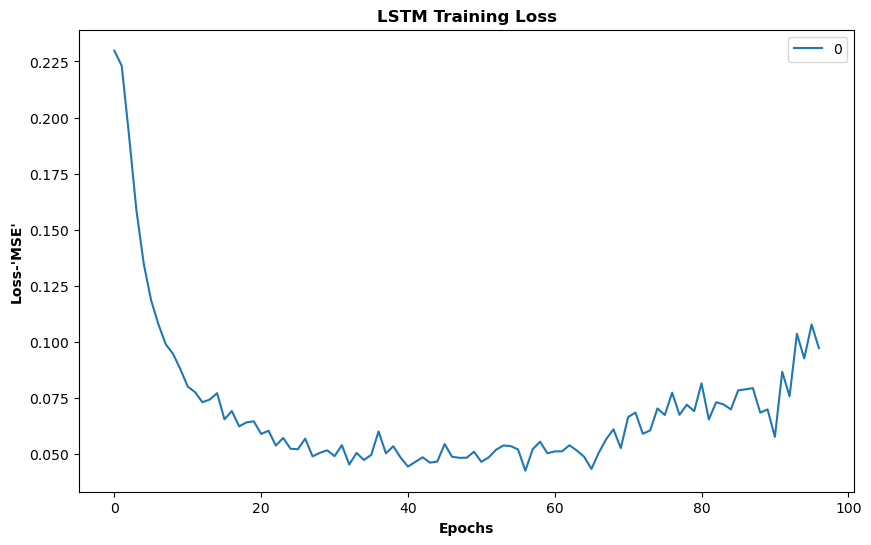

In [106]:
loss = pd.DataFrame(model.history.history['val_loss'])
loss.plot(figsize=(10,6))
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold')

In [107]:
#loss = pd.DataFrame(model.history.history['mean_absolute_percentage_error'])
#loss.plot(figsize=(10,6))
#plt.title('LSTM Training Loss',fontweight='bold')
#plt.xlabel('Epochs',fontweight='bold')
#plt.ylabel("Loss-'MSE'",fontweight='bold')

In [108]:
#loss = pd.DataFrame(model.history.history['val_mean_absolute_percentage_error'])
#loss.plot(figsize=(10,6))
#plt.title('LSTM Training Loss',fontweight='bold')
#plt.xlabel('Epochs',fontweight='bold')
#plt.ylabel("Loss-'MSE'",fontweight='bold')

##Predictions

In [109]:
# demonstrate prediction
#x_input = array([[10,22,19.7],[10,22,19.7],[10,22,19.7],[10,22,19.7],[10,22,19.7]])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

In [110]:
#new=np.array([[30.43,31.040001,28.84],[30.43,31.040001,28.84],[30.43,31.040001,28.84],[30.43,31.040001,28.84],[30.43,31.040001,28.84]])
#new.shape

In [111]:
#[vixarray5[i],vixarray5[i+1],vixarray5[i+2],vixarray5[i+3],vixarray5[i+4],vixarray5[i+5],vixarray5[i+6],vixarray5[i+7],vixarray5[i+8],vixarray5[i+9],vixarray5[i+10],vixarray5[i+11],vixarray5[i+12],vixarray5[i+13],vixarray5[i+14]]

In [112]:
#new=[]
#for i in range(0,n_steps):
#  new.append(vixarray5[i])

#new

In [113]:
predict=np.empty(shape=(0,7))
for i in range(0,len(vixarray5)-n_steps):
  new=[]
  for j in range(0,n_steps):
    new.append(vixarray5[j+i])
  x_input = np.array(new)
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  predict=np.append(predict,yhat,axis=0)

In [114]:
predict

array([[-6.61586463e-01, -6.38103247e-01, -6.24407887e-01, ...,
         5.92480898e-01,  5.81652403e-01,  5.65940738e-01],
       [-6.67596221e-01, -6.44373894e-01, -6.30636990e-01, ...,
         5.91300130e-01,  5.79321146e-01,  5.61999798e-01],
       [-6.73666716e-01, -6.50533617e-01, -6.36681557e-01, ...,
         5.90666652e-01,  5.77651978e-01,  5.58851361e-01],
       ...,
       [-1.76690832e-01, -1.36050805e-02,  7.77371228e-04, ...,
        -5.44833541e-01, -7.24053144e-01, -1.17229271e+00],
       [-1.85476199e-01, -2.27875784e-02, -9.54272598e-03, ...,
        -5.50635993e-01, -7.29656816e-01, -1.17161262e+00],
       [-1.93478778e-01, -3.12120840e-02, -1.91652402e-02, ...,
        -5.55837154e-01, -7.34833837e-01, -1.17083859e+00]])

In [115]:
predictopen=[]
for i in predict:
  predictopen.append(i[0])

In [116]:
vixsc5open=[]
for i in vixsc5:
  vixsc5open.append(i[0])

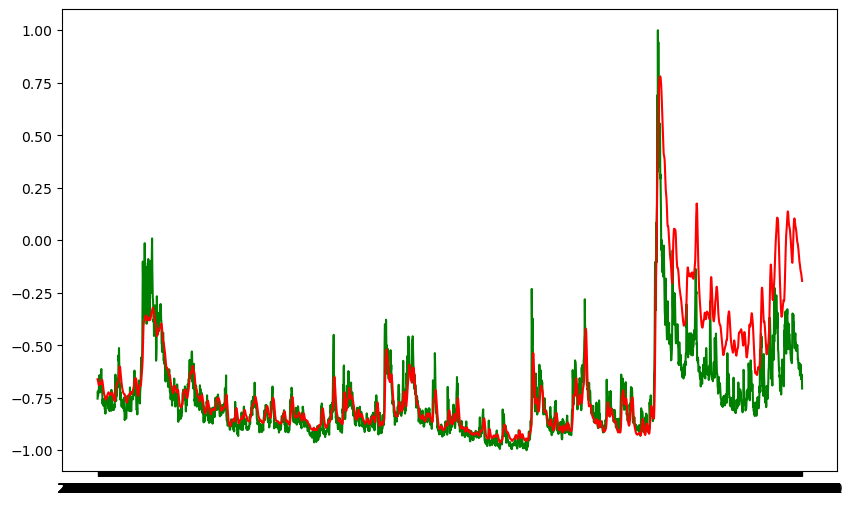

In [117]:
plt.figure(figsize=(10,6))
plt.plot(vix5["Date"][n_steps:], vixsc5open[n_steps:], 'g-')
plt.plot(vix5["Date"][n_steps:], predictopen, 'r-')

In [118]:
#for i in range(len(predictopen)-1):
 # print(vix5["Open"][i],predictopen[i])

In [119]:
len(predictopen)

2961

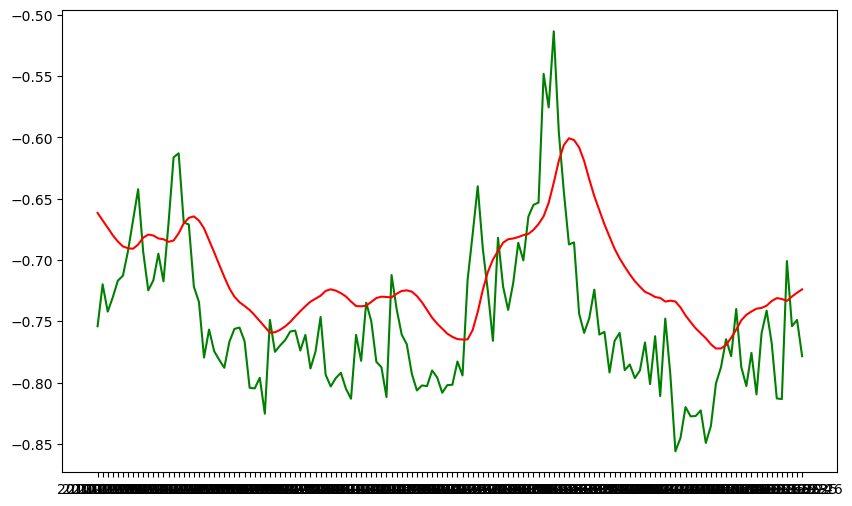

In [120]:
a=n_steps
b=200
plt.figure(figsize=(10,6))
plt.plot(vix5["Date"][a:b], vixsc5open[a:b], 'g-')
plt.plot(vix5["Date"][a:b], predictopen[a-n_steps:b-n_steps], 'r-')

In [121]:
#vix1 = pd.read_csv('/content/^VIX (2).csv')
#vixarray=vix1
#vixarray.index = vixarray['Date']
#vixarray=vixarray[['Open','High','Low']]
#vixarray=np.array(vixarray)

In [122]:
#vixsc1=sc.fit_transform(vix1[['Open','High','Low']])
#vixarray=sc.fit_transform(vixarray)
#vixsc1open=[]
#for i in vixsc1:
 # vixsc1open.append(i[0])

In [123]:
# demonstrate prediction
#x_input = array([[10,22,19.7],[10,22,19.7],[10,22,19.7],[10,22,19.7],[10,22,19.7]])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

In [124]:
predict=np.empty(shape=(0,7))
for i in range(0,len(vixarray)-n_steps):
  new=[]
  for j in range(0,n_steps):
    new.append(vixarray[j+i])
  x_input = np.array(new)
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  predict=np.append(predict,yhat,axis=0)

In [125]:
predictopen=[]
for i in predict:
  predictopen.append(i[0])

In [126]:
vixsc1open=[]
for i in vixsc:
  vixsc1open.append(i[0])

In [127]:
#something wrong with length of vix 1 year

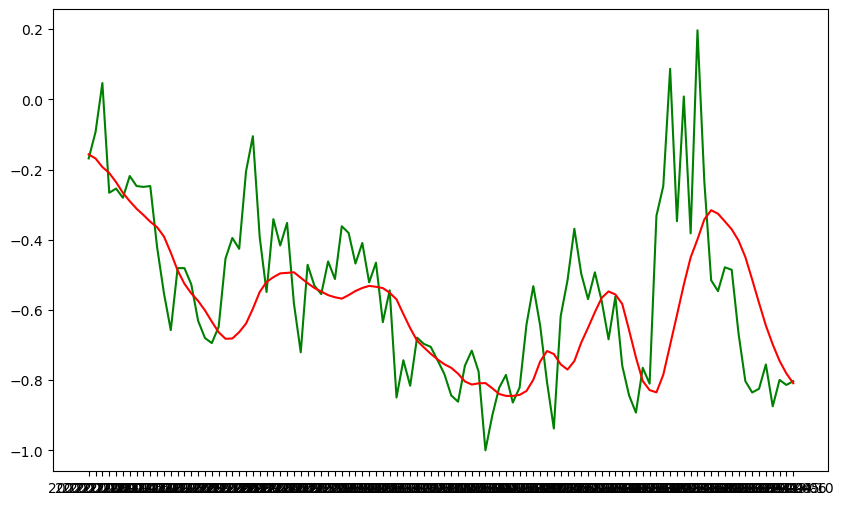

In [128]:
plt.figure(figsize=(10,6))
plt.plot(vix["Date"][n_steps:], vixsc1open[n_steps:], 'g-')
plt.plot(vix["Date"][n_steps:], predictopen[:104], 'r-')

In [129]:
#for i in range(len(predictopen)-1):
 # print(vix5["Open"][i],predictopen[i])

In [130]:
len(vixsc1open)

164

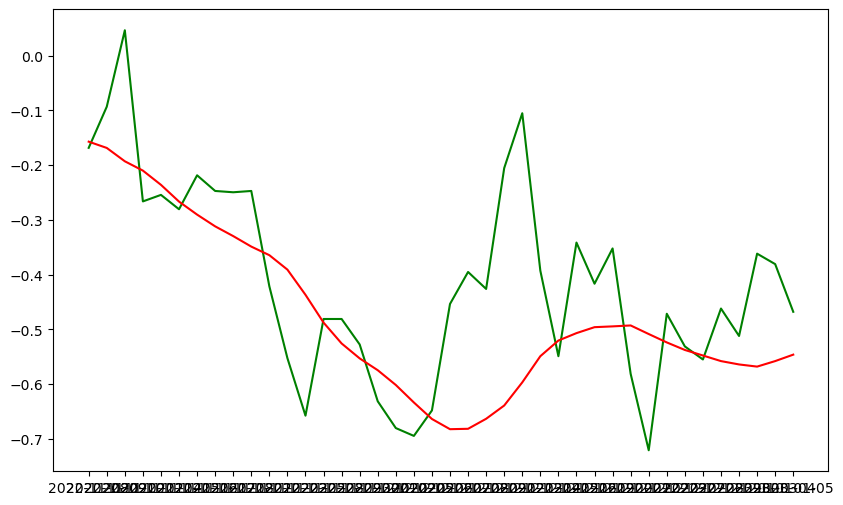

In [131]:
a=n_steps
b=100
plt.figure(figsize=(10,6))
plt.plot(vix["Date"][a:b], vixsc1open[a:b], 'g-')
plt.plot(vix["Date"][a:b], predictopen[a-n_steps:b-n_steps], 'r-')

##Predictions V2

In [132]:
#vix1 = pd.read_csv('/content/^VIX (2).csv')
#vixarray=vix1
#vixarray.index = vixarray['Date']
#vixarray=vixarray[['Open','High','Low']]
#vixarray=np.array(vixarray)

In [133]:
#vixsc1=sc.fit_transform(vix1[['Open','High','Low']])
#vixarray=sc.fit_transform(vixarray)
#vixsc1open=[]
#for i in vixsc1:
#  vixsc1open.append(i[0])

In [134]:
# demonstrate prediction
#x_input = array([[10,22,19.7],[10,22,19.7],[10,22,19.7],[10,22,19.7],[10,22,19.7]])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

In [135]:
new=[]
for i in range(0,n_steps):
  new.append(vixarray5[i])


In [136]:
predict=np.empty(shape=(0,7))
for i in range(0,len(vixarray)-n_steps):
  new=[]
  for j in range(0,n_steps):
    new.append(vixarray[j+i])
  x_input = np.array(new)
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  predict=np.append(predict,yhat,axis=0)

In [137]:
#predict[0]

In [138]:
predictopen=[]
for i in predict:
  predictopen.append(i[0])

In [139]:
#vix['Open']

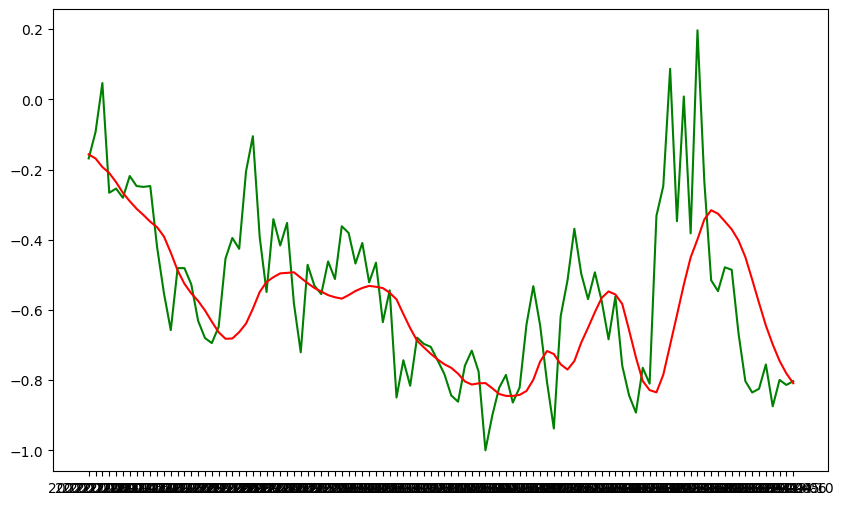

In [140]:
plt.figure(figsize=(10,6))
plt.plot(vix["Date"][n_steps:], vixsc1open[n_steps:], 'g-')
plt.plot(vix["Date"][n_steps:], predictopen[:104], 'r-')

In [141]:
#for i in range(len(predictopen)-1):
 # print(vix5["Open"][i],predictopen[i])

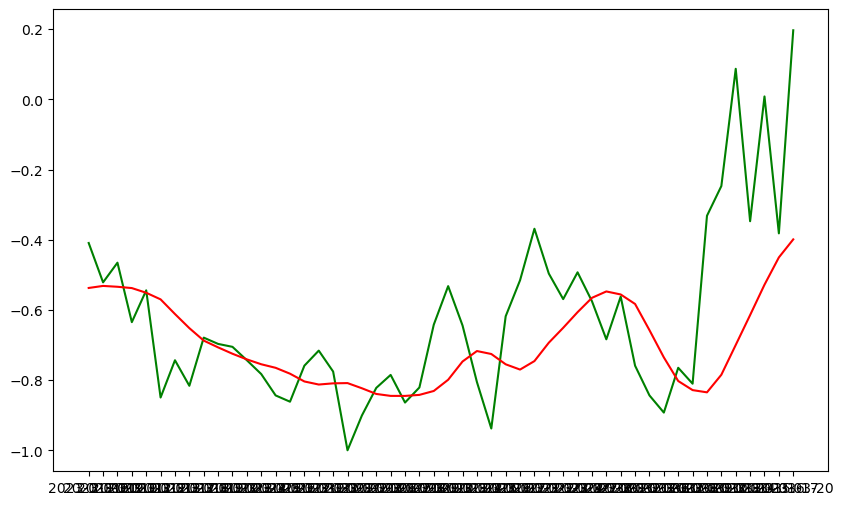

In [142]:
a=100
b=150
plt.figure(figsize=(10,6))
plt.plot(vix["Date"][a:b], vixsc1open[a:b], 'g-')
plt.plot(vix["Date"][a:b], predictopen[a-n_steps:b-n_steps], 'r-')

##Change

In [143]:
len(vixsc1open)

164

In [144]:
changevix=[]
changepredict=[]
vixpercent=[]
predictpercent=[]

for i in range(0,len(vixsc1open)-2):
  if vixsc1open[1]<vixsc1open[1]:
    changevix.append(1)
  elif vixsc1open[1]>vixsc1open[1]:
    changevix.append(-1)
  else:
    changevix.append(0)

  vixpercent.append(vixsc1open[i+1]-vixsc1open[i])

for i in range(0,len(predictopen)-2):
  if predictopen[i]<predictopen[i+1]:
    changepredict.append(1)
  elif predictopen[i]<predictopen[i+1]:
    changepredict.append(-1)
  else:
    changepredict.append(0)

  predictpercent.append(predictopen[i+1]-predictopen[i])

In [145]:
(predictopen[1]-predictopen[0])/predictopen[0],predictopen[1],predictopen[0]

(0.07295193758944214, -0.1684095561504364, -0.15695908665657043)

In [146]:
count=0
for i in range(len(changepredict)-1):
  if changevix[i]==changepredict[i]:
    count+=1
count

67

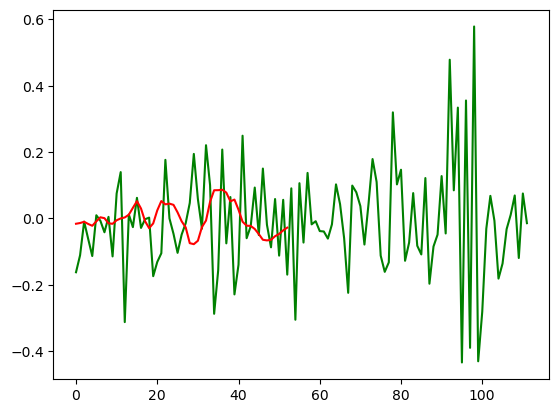

In [147]:
a=50
b=200
plt.plot(vixpercent[a:b], 'g-')
plt.plot(predictpercent[a:b], 'r-')

#Save Model

In [148]:
#model.save('vixmodel')

In [149]:
#yes = tf.keras.models.load_model('vixmodel')

In [150]:
#yes.summary()